In [30]:
import os
import numpy as np
import pandas as pd
import cv2 # OpenCV
from alive_progress import alive_bar
import time
from pathlib import Path
from sklearn.svm import SVC # SVM klasifikator
from skimage.feature import hog as HOG
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import pickle
import sys
from tqdm import tqdm
from time import sleep
%matplotlib inline

100%|██████████████████████████████████████████████████████████████████████████████| 2687/2687 [00:31<00:00, 85.32it/s]
Mask on count:  1760
Mask off count:  218
No face count:  709


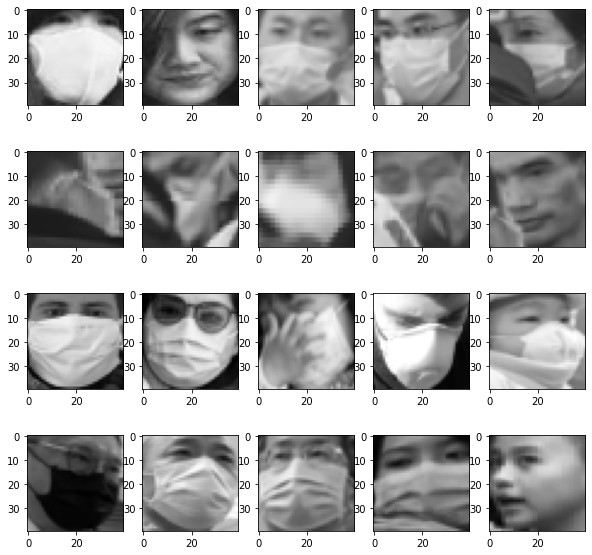

In [31]:
data = pd.read_csv(str(Path().absolute()) + "\\data.csv")

pd.options.mode.chained_assignment = None  # default='warn'

img_base_path = str(Path().absolute()) + "\\archive\\images\\"

i = 0
width = 40
height = 40
dim = (width, height)

fig = plt.figure(figsize=(10, 10))  # width, height in inches

images = []

# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3


classifier_mask_on_labels = []
classifier_mask_off_labels = []

computed_mask_on_features = []
computed_mask_off_features = []
computed_no_face_features = []

classifier_mask_labels = []
computed_mask_features = []
 
with tqdm(total=len(data['file']), file=sys.stdout) as pbar:
    for fileName in data['file']:
        pbar.update(1)
        image=cv2.imread(img_base_path + fileName)
        [xmin,ymin,xmax,ymax]=data.iloc[i:i+1,0:4].values.tolist()[0]
        cropped_image=image[ymin:ymax,xmin:xmax]

        gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

        scaled = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)
        images.append(scaled)
        
        # fd= feature descriptor
        fd = HOG(scaled, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)

        if data['class'][i] == 0 or data['class'][i] == 1:
            classifier_mask_on_labels.append(1)
            computed_mask_on_features.append(fd)
            
            classifier_mask_labels.append(1)
            computed_mask_features.append(fd)
            
        elif data['class'][i] == 2:
            classifier_mask_off_labels.append(1)
            computed_mask_off_features.append(fd)
            
            classifier_mask_labels.append(0)
            computed_mask_features.append(fd)
            
        elif data['class'][i] == -1:
            classifier_mask_on_labels.append(0)
            classifier_mask_off_labels.append(0)
            computed_no_face_features.append(fd)
        i += 1

print('Mask on count: ', len(computed_mask_on_features))
print('Mask off count: ', len(computed_mask_off_features))
print('No face count: ', len(computed_no_face_features))

i = 0
for imageFile in images[0:20]:
    sub = fig.add_subplot(4, 5, i + 1)
    plt.imshow(cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB))
    i += 1

In [32]:
pos_features_mask_on = np.array(computed_mask_on_features)
pos_features_mask_off = np.array(computed_mask_off_features)
neg_features = np.array(computed_no_face_features)

x_mask_on = np.vstack((pos_features_mask_on, neg_features))
y_mask_on = np.array(classifier_mask_on_labels)

x_mask_off = np.vstack((pos_features_mask_off, neg_features))
y_mask_off = np.array(classifier_mask_off_labels)

x_mask = np.array(computed_mask_features)
y_mask = np.array(classifier_mask_labels)

In [33]:
x_train_mask_on, x_test_mask_on, y_train_mask_on, y_test_mask_on = train_test_split(x_mask_on, y_mask_on, test_size=0.2, random_state=42)
print("Mask On Classifier:")
print('\tTrain shape: ', x_train_mask_on.shape)
print('\tTest shape: ', x_test_mask_on.shape)

x_train_mask_off, x_test_mask_off, y_train_mask_off, y_test_mask_off = train_test_split(x_mask_off, y_mask_off, test_size=0.2, random_state=42)
print("Mask Off Classifier:")
print('\tTrain shape: ', x_train_mask_off.shape)
print('\tTest shape: ', x_test_mask_off.shape)

x_train_mask, x_test_mask, y_train_mask, y_test_mask = train_test_split(x_mask, y_mask, test_size=0.2, random_state=42)
print("Mask Classifier:")
print('\tTrain shape: ', x_train_mask.shape)
print('\tTest shape: ', x_test_mask.shape)

Mask On Classifier:
	Train shape:  (1975, 576)
	Test shape:  (494, 576)
Mask Off Classifier:
	Train shape:  (741, 576)
	Test shape:  (186, 576)
Mask Classifier:
	Train shape:  (1582, 576)
	Test shape:  (396, 576)


In [34]:
mask_on_classifier = SVC(kernel = 'rbf',gamma='scale', probability=True)
mask_on_classifier.fit(x_train_mask_on, y_train_mask_on)
y_train_pred_mask_on = mask_on_classifier.predict(x_train_mask_on)
y_test_pred_mask_on = mask_on_classifier.predict(x_test_mask_on)
print("Mask On Classifier:")
print("\tTrain accuracy: ", accuracy_score(y_train_mask_on, y_train_pred_mask_on))
print("\tValidation accuracy: ", accuracy_score(y_test_mask_on, y_test_pred_mask_on))

mask_off_classifier = SVC(kernel = 'rbf',gamma='scale', probability=True)
mask_off_classifier.fit(x_train_mask_off, y_train_mask_off)
y_train_pred_mask_off = mask_off_classifier.predict(x_train_mask_off)
y_test_pred_mask_off = mask_off_classifier.predict(x_test_mask_off)
print("Mask Off Classifier:")
print("\tTrain accuracy: ", accuracy_score(y_train_mask_off, y_train_pred_mask_off))
print("\tValidation accuracy: ", accuracy_score(y_test_mask_off, y_test_pred_mask_off))

mask_classifier = SVC(kernel = 'rbf',gamma='scale', probability=True)
mask_classifier.fit(x_train_mask, y_train_mask)
y_train_pred_mask = mask_classifier.predict(x_train_mask)
y_test_pred_mask = mask_classifier.predict(x_test_mask)
print("Mask Classifier:")
print("\tTrain accuracy: ", accuracy_score(y_train_mask, y_train_pred_mask))
print("\tValidation accuracy: ", accuracy_score(y_test_mask, y_test_pred_mask))

Mask On Classifier:
	Train accuracy:  0.9924050632911392
	Validation accuracy:  0.9655870445344129
Mask Off Classifier:
	Train accuracy:  0.9878542510121457
	Validation accuracy:  0.9516129032258065
Mask Classifier:
	Train accuracy:  0.9753476611883691
	Validation accuracy:  0.9444444444444444


In [35]:
#best score
    #mask on: 0.969
    #mask off: 0.951
    #mask: 0.949

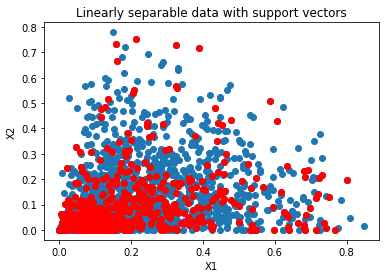

In [36]:
# Get support vectors themselves
support_vectors = mask_on_classifier.support_vectors_

# Visualize support vectors
plt.scatter(x_train_mask_on[:,0], x_train_mask_on[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [37]:
"""
i = 0
for imageFile in images[0:x_train.shape[0]]:
    if y_train[i] == y_train_pred[i]:
        features = HOG(imageFile, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True).reshape(1, -1)
        plt.figure()
        plt.imshow(cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB))
        plt.title("indx " + str(i + 2) + " labeled " + str(y_train[i]) + " prediction " + str(y_train_pred[i]) + " - "+str(mask_on_classifier.predict_proba(features)[0]))
    i+=1
"""

'\ni = 0\nfor imageFile in images[0:x_train.shape[0]]:\n    if y_train[i] == y_train_pred[i]:\n        features = HOG(imageFile, orientations, pixels_per_cell, cells_per_block, block_norm=\'L2\', feature_vector=True).reshape(1, -1)\n        plt.figure()\n        plt.imshow(cv2.cvtColor(imageFile, cv2.COLOR_BGR2RGB))\n        plt.title("indx " + str(i + 2) + " labeled " + str(y_train[i]) + " prediction " + str(y_train_pred[i]) + " - "+str(mask_on_classifier.predict_proba(features)[0]))\n    i+=1\n'

In [38]:
pickle.dump(mask_on_classifier, open('mask_on_classifier.sav', 'wb'))
pickle.dump(mask_off_classifier, open('mask_off_classifier.sav', 'wb'))
pickle.dump(mask_classifier, open('mask_classifier.sav', 'wb'))